_________
# Recommender Systems - Movie Lens Data
_______

Hello! 

In this notebook, I will use two methods if **Collaborative Filtering** to recommend movies to the users.
- Memory-Based Collaborative Filtering by computing cosine similarity
- Model-Based Collaborative Filtering by using singular value decomposition (SVD)



## The Data
_____

We will use MovieLens dataset. It contains 100k movie ratings from 943 users and a selection of 1682 movies.

The dataset is available [here](http://files.grouplens.org/datasets/movielens/ml-100k.zip).


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Read the data in the **u.data** file, which contains the full dataset. 

A brief description of the dataset is [here](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

In [2]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']

#  it's tab serparated file
df = pd.read_csv('input/u.data', sep='\t', names=column_names)
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


We have a seperate 'Movie_Id_Title' csv file. Se will merge movie titles to the item_id so it's more than just meaningless numbers.

In [3]:
movie_titles = pd.read_csv("input/Movie_Id_Titles")
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


## Exploratory Data Analysis
________


**How many unique number of movies and users in the data?**

In [4]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+str(n_items))

Num. of Users: 944
Num of Movies: 1682


** Movies with the highest average ratings **

In [5]:
df.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Marlene Dietrich: Shadow and Light (1996)     5.0
Prefontaine (1997)                            5.0
Santa with Muscles (1996)                     5.0
Star Kid (1997)                               5.0
Someone Else's America (1995)                 5.0
Name: rating, dtype: float64

** Movies with the most number of ratings**

In [6]:
df.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Star Wars (1977)             584
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485
Name: rating, dtype: int64

Never seen those movies with the highest ratings!

Let's look more into the relationship between ratings and number of ratings by ** creating a new dataframe with average rating and number of ratings per movies.**

In [7]:
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
ratings.head()

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


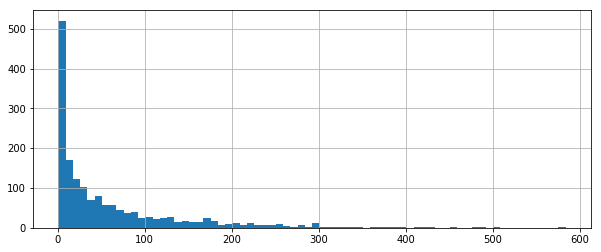

In [8]:
plt.figure(figsize=(10,4))
ratings['num of ratings'].hist(bins=70)

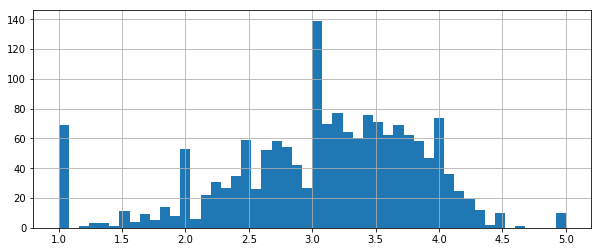

In [9]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=50)

### Obeservations 
- There are a lot of movies that has only few number of ratings.
- There are concentrations of movies with ratings 1, 2, 3, 4. Probably because of how movie rating systems are designed (can only pick whole number) and great number of movies with only few numbers of ratings.
- We will need to decide on the minimum number of ratings required for the movie for model building. 

## Train Test Split
___________

We will split the data into two sets for training and testing.

In [10]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df, test_size=0.3)

## Memory-Based Collaborative Filtering Model
____

Movie recommendation approach can be divided into two main sections: **user-item filtering** and **item-item filtering**. 

A *user-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 

* *Item-Item Collaborative Filtering*: “Users who liked this item also liked …”
* *User-Item Collaborative Filtering*: “Users who are similar to you also liked …”

For *Item-Item Collaborative Filtering* the similarity between items are measured by **observing all the users who have rated both items.**


For *User-Item Collaborative Filtering* the similarity values between users are measured by **observing all the items that are rated by both users.**

A distance metric commonly used in recommender systems is *cosine similarity*, where the ratings are seen as vectors in ``n``-dimensional space and the similarity is calculated based on the angle between these vectors. 

We will use Scikit-Learn libraries to calculate the cosine similarity. 

First, let's **create the user-item matrix for both testing and training data.**

In [11]:
#Create two user-item matrices for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

#Create two user-item matrices for testing
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

**Calculated the cosine similarity using the [pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html).**

In [12]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

Next step is to make predictions. You have already created similarity matrices: `user_similarity` and `item_similarity` and therefore you can make a prediction by applying following formula for user-based CF:

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\bar{x}_{k}&space;&plus;&space;\frac{\sum\limits_{u_a}&space;sim_u(u_k,&space;u_a)&space;(x_{a,m}&space;-&space;\bar{x_{u_a}})}{\sum\limits_{u_a}|sim_u(u_k,&space;u_a)|}"/>

You can look at the similarity between users *k* and *a* as weights that are multiplied by the ratings of a similar user *a* (corrected for the average rating of that user). You will need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that you are trying to predict. 

The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. To give an example: suppose, user *k* gives 4 stars to his favourite movies and 3 stars to all other good movies. Suppose now that another user *t* rates movies that he/she likes with 5 stars, and the movies he/she fell asleep over with 3 stars. These two users could have a very similar taste but treat the rating system differently. 

When making a prediction for item-based CF you don't need to correct for users average rating since query user itself is used to do predictions.

<img class="aligncenter size-thumbnail img-responsive" src="https://latex.codecogs.com/gif.latex?\hat{x}_{k,m}&space;=&space;\frac{\sum\limits_{i_b}&space;sim_i(i_m,&space;i_b)&space;(x_{k,b})&space;}{\sum\limits_{i_b}|sim_i(i_m,&space;i_b)|}"/>

Now let's make predictions. There are few things to keep in mind while making predictions: 
- We will need to normalize the prediction so that the ratings can stay between 1 and 5.
- Relative difference in the rating (for each user) is more important than the absolute values, because some users may tend always to give high or low rating to all movies. So when making a prediction **for user-based CF, we will want to correct for users average rating. **
- BUT when we are making predition **for item-based CF, we don't need to, because query user itself is used to do the prediction.**

In [13]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [14]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

### Evaluation of the Memory-Based CF

We will evaluate the accuracy of prediction by using **Root Mean Squared Error (RMSE)**

And also, since we only want to consider predicted ratings that are in the test dataset, we will filter out all other elements in the prediction matrix.

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth):
    # ground_truth.nonzero() used to filter out other elements
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [16]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.1583709896106478
Item-based CF RMSE: 3.4666191253751624


Welp, doesn't look too good! But it's okay. 

Drawback of Memory-Based CF is that it doesn't address the cold-start problem and it doesn't scale well to real-world scenarios. 

While cold-start problem is difficult to address, Model-Based CF Methods are scalable and can deal with higher sparsity level than Memory-Based CF Methods.

## Model-based Collaborative Filtering
_____________
### Understanding Model-based CF
Model-based Collaborative Filtering is based on **matrix factorization (MF)**.

Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. 

The goal of matrix factorization is **to learn the latent preferences of users and the latent attributes of items from known ratings**(learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items.**

When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the  user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. 

You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

Let's calculate the sparsity level of MovieLens dataset:

In [17]:
sparsity=round(1.0-len(df)/float(n_users*n_items),3)
print('The sparsity of the dataset is ' +  str(sparsity*100) + '%')

The sparsity of the dataset is 93.7%


So we do have very sparse matrix. 

Because Model-Based CF model uses data to learn the latent features not present in the data *(such as age, location, gender, directors, etc)*, it requires a lot of data to learn the latent features.

### SVD
The matrix factorization method we will be using is **Singular Value Decomposition (SVD).**

To explain, the general equation can be expressed as follows:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />


Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`*: (rows) user-to-concept similarity matrix
* *`S`* is an *`(r x r)`*: (diagonal) strength of each concept
* *`V^T`* is an *`(r x n)`*: (columns) movie-to-concept similarity matrix

Elements on the diagnoal in *`S`* are known as **singular values** of `X`*. 

The *`U`* matrix represents the feature vectors corresponding to **the users** in the hidden feature space.

The *`V`* matrix represents the feature vectors corresponding to **the items** in the hidden feature space.

Now that we kind of understand what SVD does, we can **make a prediction by taking dot product of *`U`*, *`S`* and *`V^T`*.**

In [18]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

# get SVD components from train matrix 
# k is number of singular values and vectors to compute
u, s, vt = svds(train_data_matrix, k = 20)

# created s_diag_matrix
s_diag_matrix=np.diag(s)

# get the user-based CF by taking dot product of u,s and vt
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

# get RMSE of the prediction for evaluation.
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 2.7919375093609764


### Possible Improvements
____
#### Hybrid Recommender System
As mentioned above, both Collaborative Filtering methods suffer from cold-start problem. However, models that use both ratings and content features are called **Hybrid Recommender Systems** where both Collaborative Filtering and Content-based Models are combined.

Hybrid recommender systems usually show higher accuracy than Collaborative Filtering or Content-based Models on their own: they are capable to address the cold-start problem better since if you don't have any ratings for a user or an item you could use the metadata from the user or item to make a prediction. 

#### Alternative least square and stoachastic gradient descent methods
Carelessly addressing only the relatively few known entries is highly prone to overfitting. More recent work minimizes the squared error by applying alternating least square or stochastic gradient descent and uses regularization terms to prevent overfitting.
